### Import data

In [1]:
import pandas as pd
from tabulate import tabulate
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [2]:
# Load the Excel file
file_path = r"D:\INX_Future_Employee_Performance_Project\data\processed\INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xlsx"
data = pd.read_excel(file_path)

### Imports & functions

In [3]:
from insightfulpy.eda import *
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, pearsonr, spearmanr, ttest_ind, mannwhitneyu, shapiro
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, learning_curve
)
from sklearn.preprocessing import (
     LabelEncoder, OneHotEncoder,
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, compute_class_weight
import time
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, 
    AdaBoostClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, 
    roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

In [4]:
def normality_test_with_skew_kurt(df):
    # Initialize lists to store results for normal and non-normal distributions.
    normal_cols = []
    not_normal_cols = []
    # Loop over each numeric column in the dataframe.
    for col in df.select_dtypes(include=[np.number]).columns:
        col_data = df[col].dropna()  # Remove null values from the column.
        # Ensure there are at least 3 non-NA values to perform tests.
        if len(col_data) >= 3:
            # Select appropriate normality test based on sample size.
            if len(col_data) <= 5000:
                stat, p_value = shapiro(col_data)  # Shapiro-Wilk test for smaller samples.
                test_used = 'Shapiro-Wilk'
            else:
                # Kolmogorov-Smirnov test for larger samples, using sample mean and standard deviation.
                stat, p_value = kstest(col_data, 'norm', args=(col_data.mean(), col_data.std()))
                test_used = 'Kolmogorov-Smirnov'
            # Calculate skewness and kurtosis of the column.
            col_skewness = skew(col_data)
            col_kurtosis = kurtosis(col_data)
            # Store test results in a dictionary.
            result = {
                'Column': col,
                'Test': test_used,
                'Statistic': stat,
                'p_value': p_value,
                'Skewness': col_skewness,
                'Kurtosis': col_kurtosis
            }
            # Classify the column based on the p-value.
            if p_value > 0.05:
                normal_cols.append(result)  # Considered normally distributed.
            else:
                not_normal_cols.append(result)  # Not normally distributed.
    # Create DataFrames for normal and not normal results and sort them.
    normal_df = (
        pd.DataFrame(normal_cols).sort_values(by='Column')
        if normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    not_normal_df = (
        pd.DataFrame(not_normal_cols).sort_values(by='p_value', ascending=False)
        if not_normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    # Display results for normal and not normal columns.
    print("\nNormal Columns (p > 0.05):")
    display(normal_df)
    print("\nNot Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:")
    display(not_normal_df)
    return normal_df, not_normal_df

def spearman_correlation(data, non_normal_cols, exclude_target=None, multicollinearity_threshold=0.8):
    # Exit if no non-normally distributed columns found.
    if non_normal_cols.empty:
        print("\nNo non-normally distributed numerical columns found. Exiting Spearman Correlation.")
        return
    # Prepare list of columns to analyze, excluding the target if specified.
    selected_columns = non_normal_cols['Column'].tolist()
    if exclude_target and exclude_target in selected_columns and pd.api.types.is_numeric_dtype(data[exclude_target]):
        selected_columns.remove(exclude_target)
    # Calculate Spearman correlation matrix.
    spearman_corr_matrix = data[selected_columns].corr(method='spearman')
    multicollinear_pairs = []
    # Identify pairs of variables with high correlation.
    for i, col1 in enumerate(selected_columns):
        for col2 in selected_columns[i+1:]:
            coef = spearman_corr_matrix.loc[col1, col2]
            if abs(coef) > multicollinearity_threshold:
                multicollinear_pairs.append((col1, col2, coef))
    # Display multicollinear pairs.
    print("\nVariables Exhibiting Multicollinearity (|Correlation| > {:.2f}):".format(multicollinearity_threshold))
    if multicollinear_pairs:
        for col1, col2, coef in multicollinear_pairs:
            print(f"- {col1} & {col2}: Correlation={coef:.4f}")
    else:
        print("No multicollinear pairs found.")
    # Configure and display heatmap for Spearman correlation matrix.
    annot_matrix = spearman_corr_matrix.round(2).astype(str)
    num_vars = len(selected_columns)
    fig_size = max(min(24, num_vars * 1.2), 10)  # Ensure reasonable figure size.
    annot_font_size = max(min(10, 200 / num_vars), 6)  # Adjust font size based on number of variables.
    plt.figure(figsize=(fig_size, fig_size * 0.75))
    sns.heatmap(
        spearman_corr_matrix,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        annot_kws={"size": annot_font_size},
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Spearman Correlation Matrix', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

def calculate_vif(data, exclude_target='TARGET', multicollinearity_threshold=5.0):
    # Select only numeric columns, exclude target, and drop rows with missing values
    numeric_data = data.select_dtypes(include=[np.number]).drop(columns=[exclude_target], errors='ignore').dropna()
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_data.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) 
                       for i in range(numeric_data.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    high_vif = vif_data[vif_data['VIF'] > multicollinearity_threshold]
    low_vif = vif_data[vif_data['VIF'] <= multicollinearity_threshold]
    print(f"\nVariance Inflation Factor (VIF) Scores (multicollinearity_threshold = {multicollinearity_threshold}):")
    print("\nFeatures with VIF > threshold (High Multicollinearity):")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    else:
        print("None. No features exceed the VIF threshold.")
    print("\nFeatures with VIF <= threshold (Low/No Multicollinearity):")
    if not low_vif.empty:
        print(low_vif.to_string(index=False))
    else:
        print("None. All features exceed the VIF threshold.")
    return vif_data, high_vif['Feature'].tolist()

### Basic checks and understand the data

---

In [5]:
print(data.shape)
for idx, col in enumerate(data.columns):
        print(f"{idx}: {col}")

(1200, 28)
0: EmpNumber
1: Age
2: Gender
3: EducationBackground
4: MaritalStatus
5: EmpDepartment
6: EmpJobRole
7: BusinessTravelFrequency
8: DistanceFromHome
9: EmpEducationLevel
10: EmpEnvironmentSatisfaction
11: EmpHourlyRate
12: EmpJobInvolvement
13: EmpJobLevel
14: EmpJobSatisfaction
15: NumCompaniesWorked
16: OverTime
17: EmpLastSalaryHikePercent
18: EmpRelationshipSatisfaction
19: TotalWorkExperienceInYears
20: TrainingTimesLastYear
21: EmpWorkLifeBalance
22: ExperienceYearsAtThisCompany
23: ExperienceYearsInCurrentRole
24: YearsSinceLastPromotion
25: YearsWithCurrManager
26: Attrition
27: PerformanceRating


In [6]:
data.head().T

,0,1,2,3,4
EmpNumber,E1001000,E1001006,E1001007,E1001009,E1001010
Age,32,47,40,41,60
Gender,Male,Male,Male,Male,Male
EducationBackground,Marketing,Marketing,Life Sciences,Human Resources,Marketing
MaritalStatus,Single,Single,Married,Divorced,Single
EmpDepartment,Sales,Sales,Sales,Human Resources,Sales
EmpJobRole,Sales Executive,Sales Executive,Sales Executive,Manager,Sales Executive
BusinessTravelFrequency,Travel_Rarely,Travel_Rarely,Travel_Frequently,Travel_Rarely,Travel_Rarely
DistanceFromHome,10,14,5,10,16
EmpEducationLevel,3,4,4,4,4


Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 0



<Figure size 2000x800 with 0 Axes>

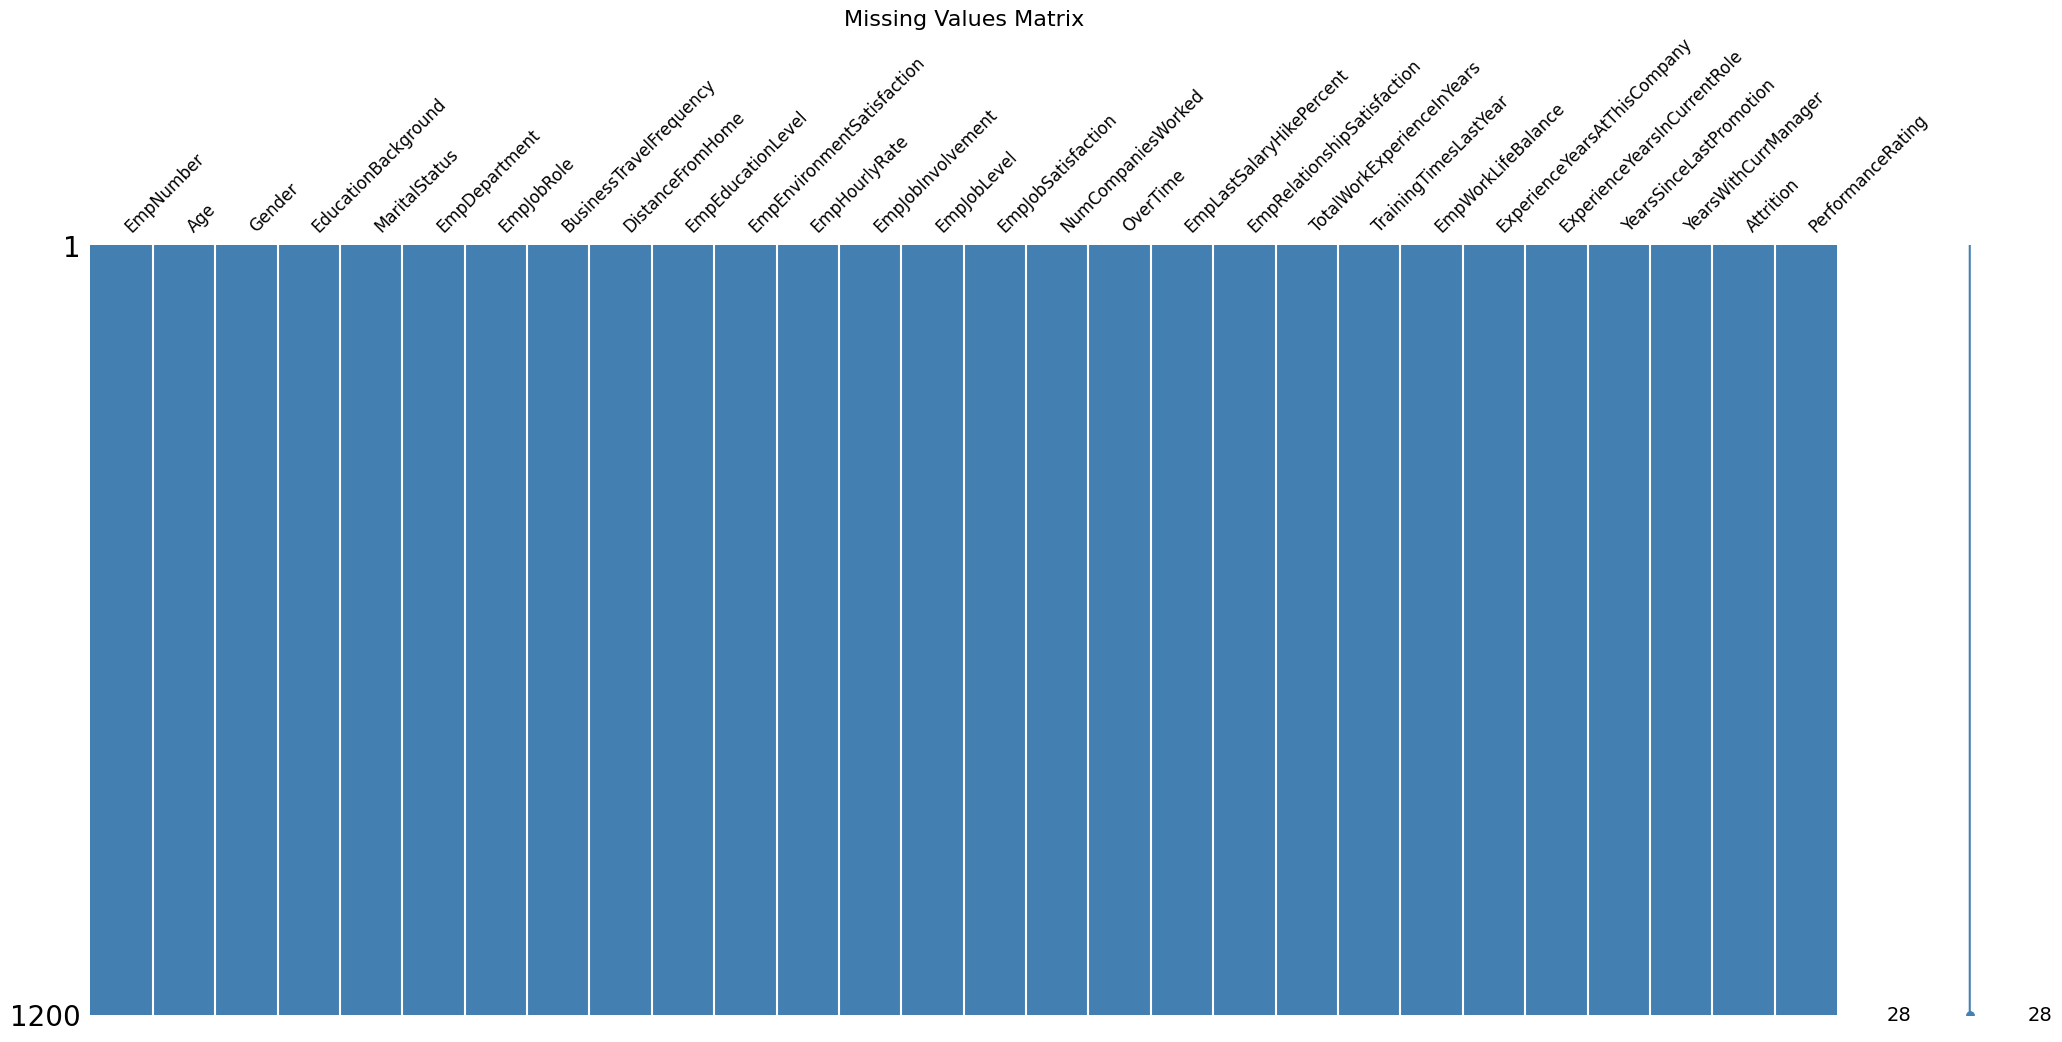

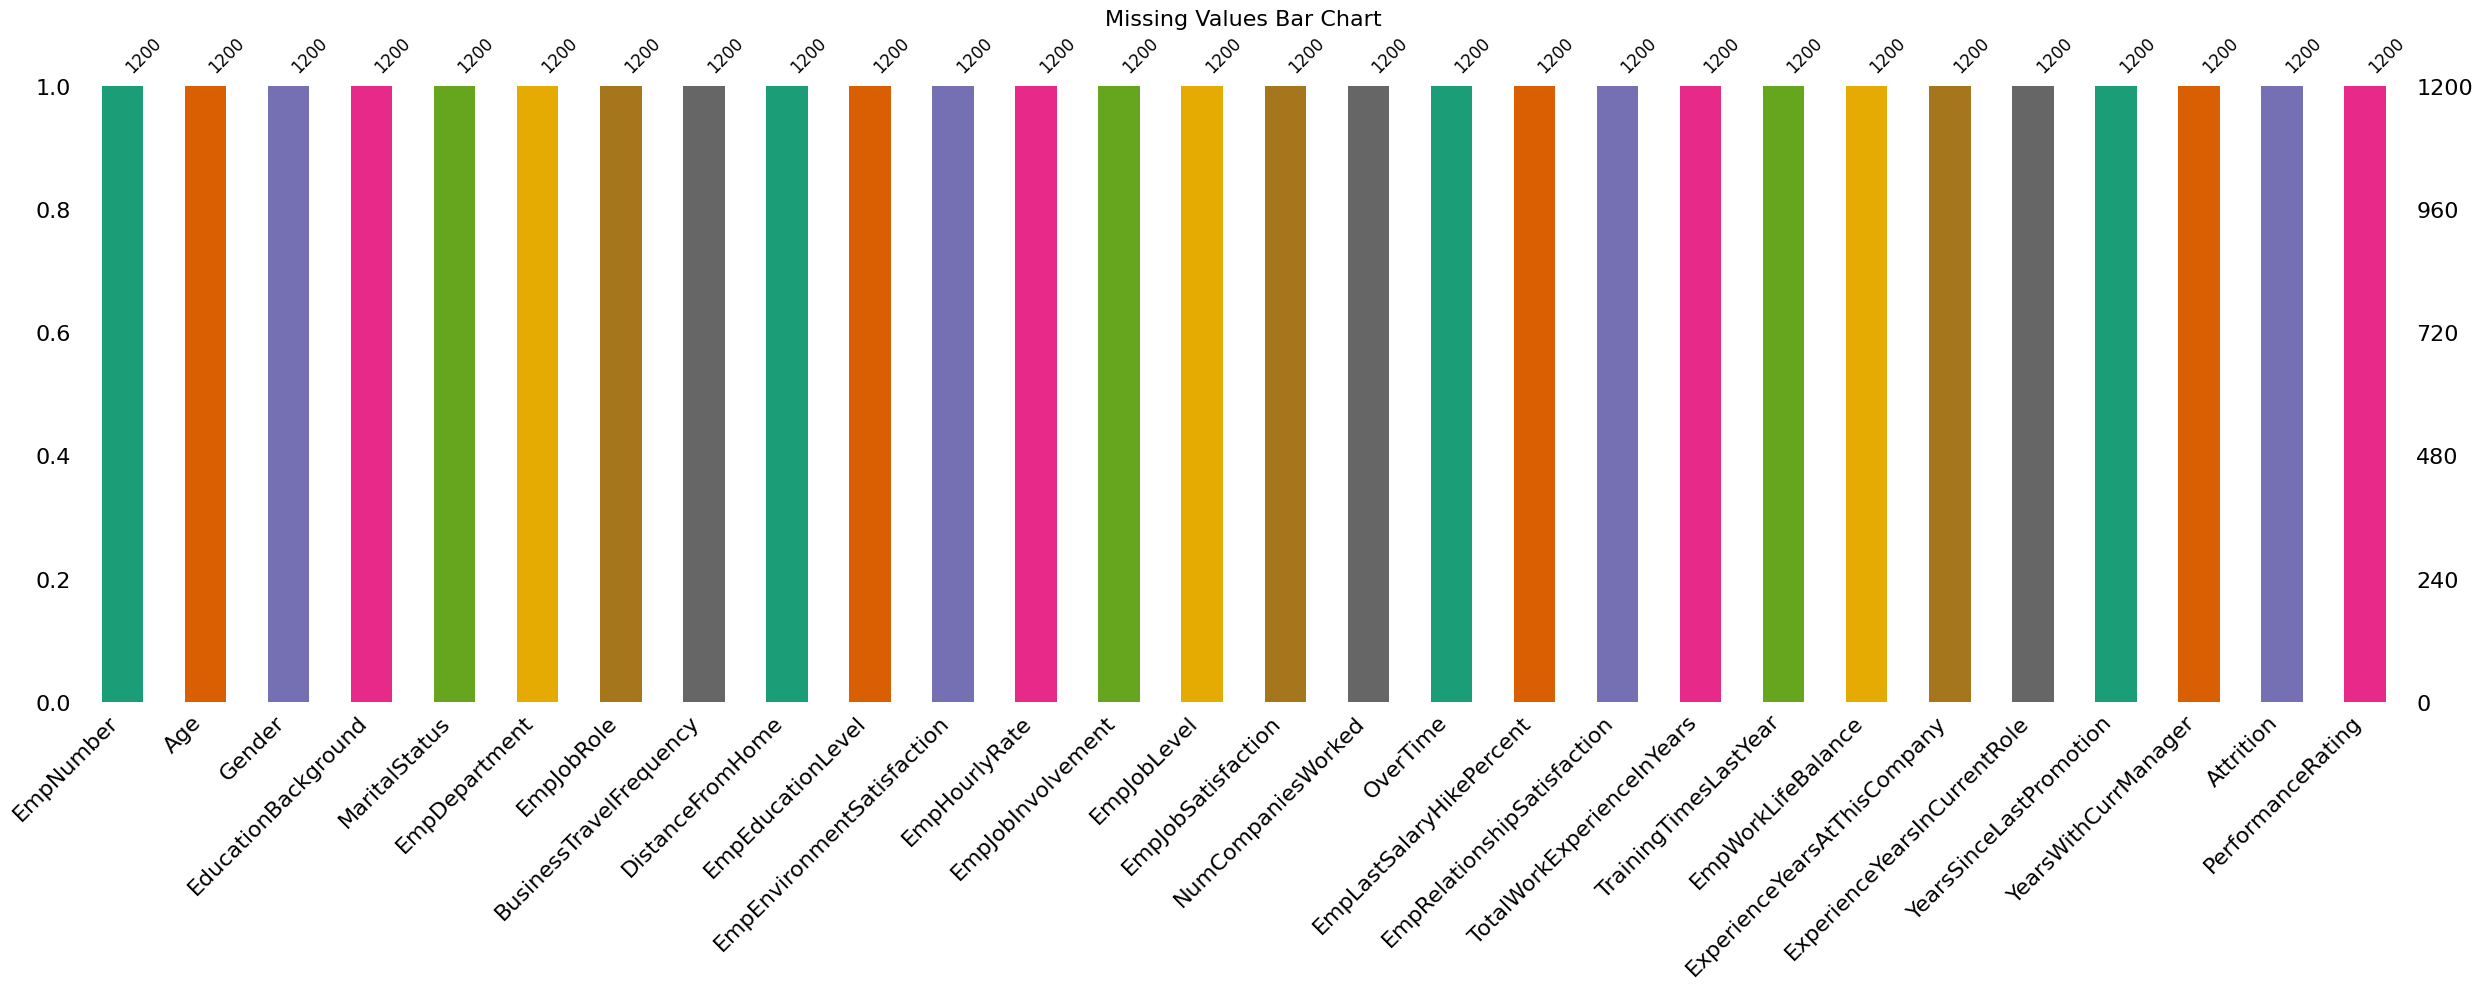

In [7]:
missing_inf_values(data)
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}\n")
duplicates = data[data.duplicated()]
duplicates
show_missing(data)

In [8]:
data_negative_values = data.select_dtypes(include=[np.number]).lt(0).sum()
data_negative_values = data_negative_values[data_negative_values > 0].sort_values(ascending=False)
print("Columns with Negative Values (Sorted):\n", data_negative_values)

Columns with Negative Values (Sorted):
 Series([], dtype: int64)


The dataset is fully intact, with no missing, infinite, or duplicate values across all 1200 records and 28 features. Each row is unique, ensuring high data integrity. Sample entries show a variety of backgrounds, departments, and performance scores, confirming diversity in roles and attributes. No additional cleaning is required at this stage, making the data immediately suitable for further analysis, modeling, and feature engineering.

# Preprocessing

---

## Data types transformation

In [9]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     1          Age                            int64           18 - 60                        43
2     8          DistanceFromHome               int64           1 - 29                         29
3     9          EmpEducationLevel              int64           1 - 5                          5
4     10         EmpEnvironmentSatisfaction     int64           1 - 4                          4
5     11         EmpHourlyRate                  int64           30 - 100                       71
6     12         EmpJobInvolvement              int64           1 - 4                          4
7     13         EmpJobLevel                    int64           1 - 5                          5
8     14         EmpJobSatisfaction             int64   

In [10]:
data = data.drop('EmpNumber', axis=1)
categorical_features = [
    'EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpJobInvolvement',
    'EmpJobLevel', 'EmpJobSatisfaction', 'EmpRelationshipSatisfaction',
    'EmpWorkLifeBalance', 'PerformanceRating', 'TrainingTimesLastYear'
]
for col in categorical_features:
    data[col] = data[col].astype('category')
# Convert object types to categorical where appropriate
object_features = [
    'Gender', 'EducationBackground', 'MaritalStatus', 'EmpDepartment',
    'EmpJobRole', 'BusinessTravelFrequency', 'OverTime', 'Attrition'
]
for col in object_features:
    data[col] = data[col].astype('category')

In [11]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     1          Gender                         category        N/A                            2
2     2          EducationBackground            category        N/A                            6
3     3          MaritalStatus                  category        N/A                            3
4     4          EmpDepartment                  category        N/A                            6
5     5          EmpJobRole                     category        N/A                            19
6     6          BusinessTravelFrequency        category        N/A                            3
7     8          EmpEducationLevel              category        N/A                            5
8     9          EmpEnvironmentSatisfaction     category  

In [12]:
analyze_data(data)





















=== Numerical Analysis ===
|    | Variable                     |    N |    Mean |      SD |     SE |   95% Conf. |   Interval |
|---:|:-----------------------------|-----:|--------:|--------:|-------:|------------:|-----------:|
|  0 | Age                          | 1200 | 36.9183 |  9.0873 | 0.2623 |     36.4037 |    37.433  |
|  1 | DistanceFromHome             | 1200 |  9.1658 |  8.1766 | 0.236  |      8.7027 |     9.6289 |
|  2 | EmpHourlyRate                | 1200 | 65.9817 | 20.2113 | 0.5835 |     64.837  |    67.1264 |
|  3 | NumCompaniesWorked           | 1200 |  2.665  |  2.4694 | 0.0713 |      2.5251 |     2.8049 |
|  4 | EmpLastSalaryHikePercent     | 1200 | 15.2225 |  3.6259 | 0.1047 |     15.0171 |    15.4279 |
|  5 | TotalWorkExperienceInYears   | 1200 | 11.33   |  7.7972 | 0.2251 |     10.8884 |    11.7716 |
|  6 | ExperienceYearsAtThisCompany | 1200 |  7.0775 |  6.2369 | 0.18   |      6.7243 |     7.4307 |
|  7 | ExperienceYearsInCurrentRole | 1200 |

The data has been successfully transformed for modeling. All categorical features, including encoded ordinal scores and string-based descriptors, are now correctly cast as category types. Irrelevant identifier EmpNumber has been removed to avoid noise. The final structure has 18 categorical and 10 numerical features.

On the numerical side, Age averages around 37, with typical ranges for experience (TotalWorkExperience ≈ 11.3 years, ExperienceAtCompany ≈ 7.1). Variables like YearsSinceLastPromotion and NumCompaniesWorked are right-skewed, and EmpHourlyRate has a wide spread from 30 to 100.

Categorical insights show a workforce dominated by males (60.42%), Life Sciences backgrounds (41%), and roles like Sales Executive (22.5%) and Developer (19.67%). Most employees rarely travel (70.5%) and do not work overtime (70.58%). Performance ratings are imbalanced—73% are rated 3 (Excellent), while ratings 2 and 4 are less common.

This transformation phase prepares the data well for encoding, feature engineering, and modeling steps, ensuring both efficiency and semantic clarity.

## outliers

In [13]:
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_outlier_summary.shape)

(6, 31)


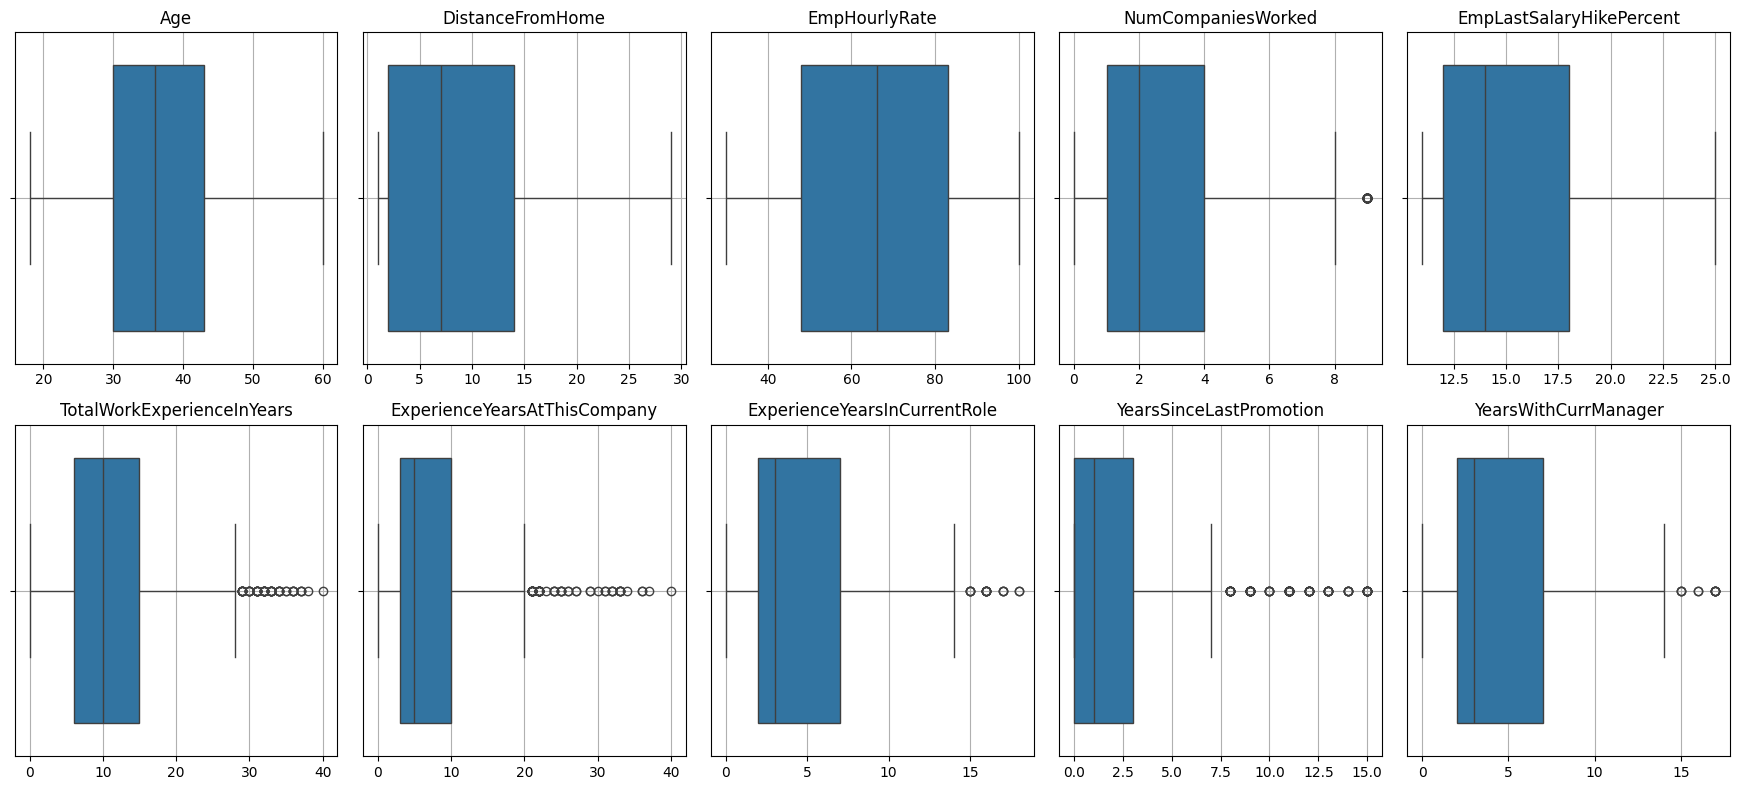

,Skewness,Kurtosis
Age,0.384145,-0.431000
DistanceFromHome,0.962956,-0.242017
EmpHourlyRate,-0.035165,-1.186891
NumCompaniesWorked,1.048635,0.068863
EmpLastSalaryHikePercent,0.808654,-0.299741
TotalWorkExperienceInYears,1.086862,0.805633
ExperienceYearsAtThisCompany,1.789055,4.057959
ExperienceYearsInCurrentRole,0.888159,0.438029
YearsSinceLastPromotion,1.974932,3.539080
YearsWithCurrManager,0.813158,0.148202


In [14]:
plot_boxplots(data)
calculate_skewness_kurtosis(data)

In [15]:
data_outlier_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value
9,24,YearsWithCurrManager,int64,1200,0.0,18,0,2.0,3.0,7.0,17,2,17,5.0,-5.5,14.5,18,3,11,0.916667,0,0,0.0,4.105000,12.542761,3.541576,0.812141,0.142589,Shapiro-Wilk,0.898841,2.100966e-27
7,22,ExperienceYearsInCurrentRole,int64,1200,0.0,19,0,2.0,3.0,7.0,18,2,18,5.0,-5.5,14.5,19,4,16,1.333333,0,0,0.0,4.291667,13.059147,3.613744,0.887048,0.431210,Shapiro-Wilk,0.899941,2.825748e-27
3,14,NumCompaniesWorked,int64,1200,0.0,10,0,1.0,2.0,4.0,9,1,9,3.0,-3.5,8.5,10,1,39,3.250000,0,0,0.0,2.665000,6.097857,2.469384,1.047324,0.063581,Shapiro-Wilk,0.846337,1.456464e-32
5,18,TotalWorkExperienceInYears,int64,1200,0.0,40,0,6.0,10.0,15.0,40,10,40,9.0,-7.5,28.5,40,11,51,4.250000,0,0,0.0,11.330000,60.796764,7.797228,1.085503,0.797285,Shapiro-Wilk,0.910346,5.310638e-26
6,21,ExperienceYearsAtThisCompany,int64,1200,0.0,37,0,3.0,5.0,10.0,40,5,40,7.0,-7.5,20.5,37,16,56,4.666667,0,0,0.0,7.077500,38.898910,6.236899,1.786818,4.036075,Shapiro-Wilk,0.836011,2.082192e-33
8,23,YearsSinceLastPromotion,int64,1200,0.0,16,0,0.0,1.0,3.0,15,0,15,3.0,-4.5,7.5,16,8,88,7.333333,0,0,0.0,2.194167,10.378448,3.221560,1.972462,3.519355,Shapiro-Wilk,0.704590,1.436331e-41


In [16]:
outlier_cols = ["YearsWithCurrManager", "ExperienceYearsInCurrentRole", "NumCompaniesWorked", "TotalWorkExperienceInYears","ExperienceYearsAtThisCompany", "YearsSinceLastPromotion"]
interconnected_outliers_df = interconnected_outliers(data, outlier_cols)


Total Interconnected Outliers: 58
Column Set Outlier Frequency:
  Columns ExperienceYearsAtThisCompany, TotalWorkExperienceInYears, YearsWithCurrManager: 1 times
  Columns TotalWorkExperienceInYears, YearsWithCurrManager: 1 times
  Columns YearsSinceLastPromotion, YearsWithCurrManager: 3 times
  Columns ExperienceYearsAtThisCompany, YearsSinceLastPromotion, YearsWithCurrManager: 1 times
  Columns ExperienceYearsAtThisCompany, YearsWithCurrManager: 1 times
  Columns ExperienceYearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager: 1 times
  Columns ExperienceYearsAtThisCompany, ExperienceYearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager: 1 times
  Columns ExperienceYearsAtThisCompany, ExperienceYearsInCurrentRole: 3 times
  Columns ExperienceYearsAtThisCompany, ExperienceYearsInCurrentRole, YearsSinceLastPromotion: 2 times
  Columns ExperienceYearsInCurrentRole, TotalWorkExperienceInYears, YearsSinceLastPromotion: 1 times
  Columns ExperienceYearsAtThisCompan

Six numerical features contain outliers, with YearsSinceLastPromotion showing the most (88 records, 7.33%). Other significant contributors include ExperienceYearsAtThisCompany (56 outliers) and TotalWorkExperienceInYears (51). Most outliers fall above the upper bound, pointing to longer tenure or delayed promotions rather than data entry issues.

Skewness values are all positive, with strongest skew in YearsSinceLastPromotion (1.97) and ExperienceYearsAtThisCompany (1.79), confirming long right tails. All variables fail the Shapiro-Wilk test (p-values < 0.05), indicating non-normal distributions.

A focused look into interconnected outliers reveals 58 records with multi-column anomalies. The most frequent pattern—15 records—shows high values in both ExperienceYearsAtThisCompany and YearsSinceLastPromotion. Another 11 records show combined outliers in ExperienceYearsAtThisCompany, TotalWorkExperienceInYears, and YearsSinceLastPromotion. These recurring patterns suggest a cluster of long-tenured employees who haven’t been promoted recently, making them prime candidates for closer workforce planning or retention analysis.

In [17]:
interconnected_outliers_df

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
25,52,Male,Marketing,Married,Sales,Manager,Travel_Rarely,3,4,3,31,2,4,1,1,No,11,1,34,3,4,34,6,1,16,No,4
72,51,Female,Marketing,Married,Sales,Manager,Travel_Rarely,26,4,1,66,3,4,3,2,No,14,3,29,2,2,20,6,4,17,No,3
283,44,Male,Other,Single,Research & Development,Research Scientist,Travel_Rarely,29,4,4,32,3,2,4,1,No,25,2,20,3,3,20,11,13,17,No,4
320,43,Female,Marketing,Single,Sales,Sales Executive,Travel_Rarely,4,4,4,56,2,3,4,3,No,14,4,23,3,4,21,7,15,17,No,3
655,40,Male,Life Sciences,Divorced,Research & Development,Manager R&D,Travel_Rarely,1,4,1,98,3,4,1,2,No,11,1,22,3,3,19,7,11,16,No,2
785,44,Female,Medical,Married,Development,Developer,Travel_Rarely,7,4,1,42,2,3,4,3,No,14,4,24,4,3,22,6,5,17,No,3
864,51,Male,Life Sciences,Single,Development,Developer,Travel_Rarely,6,3,1,51,3,5,3,7,No,13,3,23,5,3,20,18,15,15,No,3
956,42,Male,Technical Degree,Married,Development,Developer,Travel_Rarely,4,2,3,58,3,5,4,1,No,11,4,22,3,3,22,17,11,15,No,3
1083,37,Female,Life Sciences,Divorced,Development,Delivery Manager,Travel_Rarely,14,3,4,95,3,1,1,1,No,12,3,18,2,2,18,7,12,17,No,3
175,41,Female,Life Sciences,Divorced,Research & Development,Research Director,Non-Travel,7,1,2,55,1,5,3,1,No,22,2,21,3,3,21,16,5,10,No,2


In [18]:
# Perform domain-aware sanity checks
sanity_checks = {
    "Promotion vs Company Tenure": data["YearsSinceLastPromotion"] <= data["ExperienceYearsAtThisCompany"],
    "Company Tenure vs Total Experience": data["ExperienceYearsAtThisCompany"] <= data["TotalWorkExperienceInYears"],
    "Manager Tenure vs Company Tenure": data["YearsWithCurrManager"] <= data["ExperienceYearsAtThisCompany"],
    "Current Role Tenure vs Company Tenure": data["ExperienceYearsInCurrentRole"] <= data["ExperienceYearsAtThisCompany"]
}
# Create a DataFrame to track violations
sanity_check_df = pd.DataFrame({name: ~condition for name, condition in sanity_checks.items()})
sanity_check_df["Any Violation"] = sanity_check_df.any(axis=1)
# Count violations
violation_summary = sanity_check_df.sum()
# Extract violating records
violations = data[sanity_check_df["Any Violation"]]
# Output both summary and violating records
violation_summary, violations

(Promotion vs Company Tenure              0
 Company Tenure vs Total Experience       0
 Manager Tenure vs Company Tenure         0
 Current Role Tenure vs Company Tenure    0
 Any Violation                            0
 dtype: int64,
 Empty DataFrame
 Columns: [Age, Gender, EducationBackground, MaritalStatus, EmpDepartment, EmpJobRole, BusinessTravelFrequency, DistanceFromHome, EmpEducationLevel, EmpEnvironmentSatisfaction, EmpHourlyRate, EmpJobInvolvement, EmpJobLevel, EmpJobSatisfaction, NumCompaniesWorked, OverTime, EmpLastSalaryHikePercent, EmpRelationshipSatisfaction, TotalWorkExperienceInYears, TrainingTimesLastYear, EmpWorkLifeBalance, ExperienceYearsAtThisCompany, ExperienceYearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, Attrition, PerformanceRating]
 Index: [])

In [19]:
# Capping TotalWorkExperienceInYears at 95th percentile
cap_value = data['TotalWorkExperienceInYears'].quantile(0.95)
data['TotalWorkExperienceInYears'] = data['TotalWorkExperienceInYears'].clip(upper=cap_value)

In [20]:
# Capping TotalWorkExperienceInYears at 95th percentile
cap_value = data['ExperienceYearsAtThisCompany'].quantile(0.95)
data['ExperienceYearsAtThisCompany'] = data['ExperienceYearsAtThisCompany'].clip(upper=cap_value)

In [21]:
# Define upper caps based on domain-informed thresholds for outlier treatment
caps = {
    "ExperienceYearsInCurrentRole": 14,
    "YearsSinceLastPromotion": 10,
    "YearsWithCurrManager": 14,
    "NumCompaniesWorked": 8
}
# Apply winsorization (capping at upper threshold)
for col, cap in caps.items():
    data[col] = data[col].clip(upper=cap)

In [22]:
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_outlier_summary.shape)

(1, 31)


In [23]:
data_outlier_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value
8,23,YearsSinceLastPromotion,int64,1200,0.0,11,0,0.0,1.0,3.0,10,0,10,3.0,-4.5,7.5,11,3,88,7.333333,0,0,0.0,2.0775,8.136608,2.852474,1.563034,1.351387,Shapiro-Wilk,0.729212,2.646632e-40


All domain-specific sanity checks passed successfully—no logical inconsistencies were found between tenure, promotions, or manager associations. Each of the 1200 records aligns with real-world constraints, reinforcing data reliability.

Post outlier capping, extreme values across five tenure-related features have been handled using a mix of percentile-based (95th) and domain-informed thresholds. The result significantly reduced the outlier load: only YearsSinceLastPromotion still contains 88 mild outliers (7.3%), which remain above the upper bound of 7.5. This feature is inherently skewed due to a heavy concentration at zero, explaining its persistent non-normal distribution (skewness = 1.56, kurtosis = 1.35). However, since this behavior reflects genuine promotion delays, the column is still valid for modeling.

The capping step preserves data integrity while reducing variance and the risk of distortion in downstream algorithms.

## Correlation & Statistical Tests

In [24]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


,Column,Test,Statistic,p_value,Skewness,Kurtosis



Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


,Column,Test,Statistic,p_value,Skewness,Kurtosis
0,Age,Shapiro-Wilk,0.979036,3.557677e-12,0.383665,-0.434202
2,EmpHourlyRate,Shapiro-Wilk,0.955943,1.545036e-18,-0.035121,-1.186947
5,TotalWorkExperienceInYears,Shapiro-Wilk,0.918871,7.185568e-25,0.817778,-0.140970
4,EmpLastSalaryHikePercent,Shapiro-Wilk,0.904184,9.072310e-27,0.807642,-0.303489
7,ExperienceYearsInCurrentRole,Shapiro-Wilk,0.903614,7.737932e-27,0.737315,-0.213508
9,YearsWithCurrManager,Shapiro-Wilk,0.901686,4.543590e-27,0.689748,-0.410342
6,ExperienceYearsAtThisCompany,Shapiro-Wilk,0.883782,4.591052e-29,1.065351,0.445531
1,DistanceFromHome,Shapiro-Wilk,0.857049,1.225987e-31,0.961752,-0.246005
3,NumCompaniesWorked,Shapiro-Wilk,0.845823,1.318710e-32,0.950704,-0.261554
8,YearsSinceLastPromotion,Shapiro-Wilk,0.729212,2.646632e-40,1.563034,1.351387



Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
- ExperienceYearsInCurrentRole & ExperienceYearsAtThisCompany: Correlation=0.8697
- YearsWithCurrManager & ExperienceYearsAtThisCompany: Correlation=0.8406


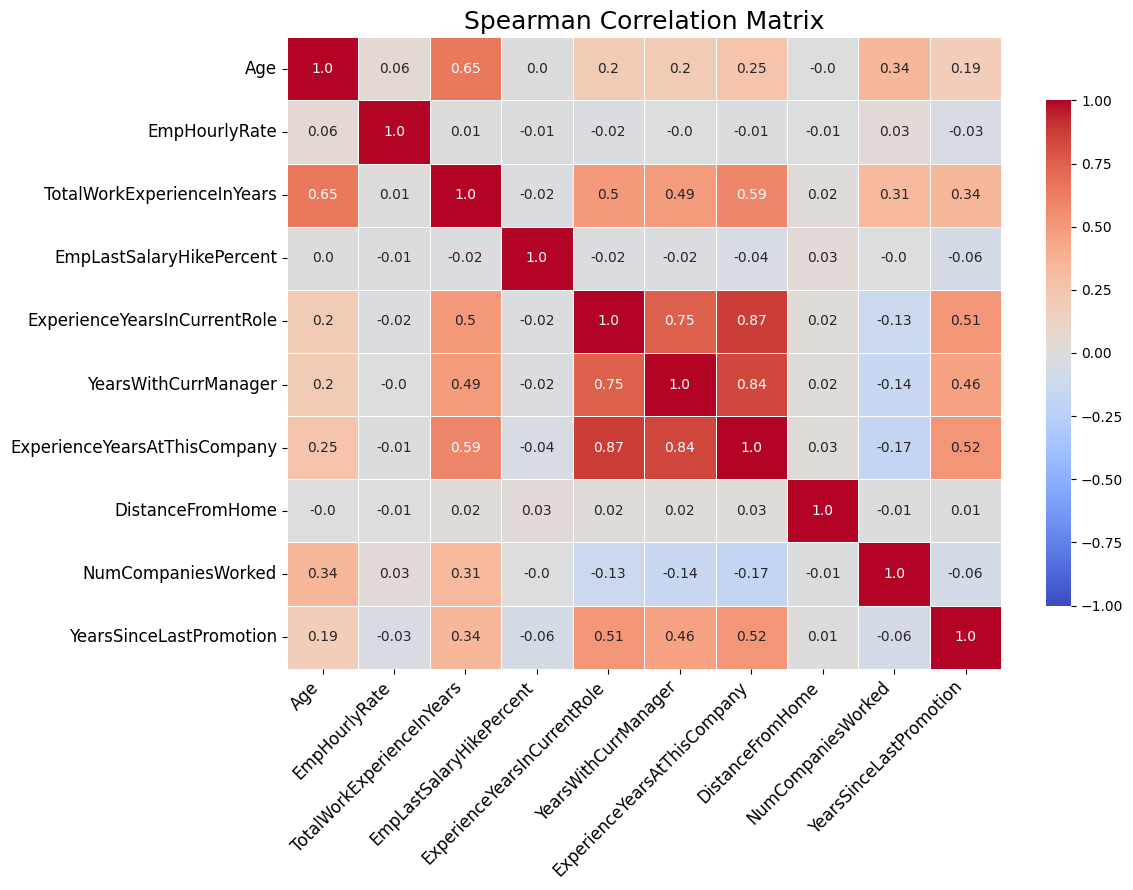

In [25]:
spearman_correlation(data, data_not_normal_df, exclude_target='PerformanceRating', multicollinearity_threshold=0.8)

In [26]:
above_threshold, below_threshold = calculate_vif(data, exclude_target='PerformanceRating', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
                     Feature       VIF
                         Age 23.312302
ExperienceYearsAtThisCompany 15.375206
    EmpLastSalaryHikePercent 12.077307
               EmpHourlyRate  9.590452
  TotalWorkExperienceInYears  9.175439
ExperienceYearsInCurrentRole  8.090152

Features with VIF <= threshold (Low/No Multicollinearity):
                Feature      VIF
   YearsWithCurrManager 7.358056
     NumCompaniesWorked 2.725663
YearsSinceLastPromotion 2.492050
       DistanceFromHome 2.235304


All numerical features failed the normality test (p-values ≤ 0.05), confirming that none follow a Gaussian distribution. This justifies using Spearman correlation, which is non-parametric and rank-based. Among those, strong multicollinearity persists:

ExperienceYearsInCurrentRole and ExperienceYearsAtThisCompany (ρ = 0.87)

YearsWithCurrManager and ExperienceYearsAtThisCompany (ρ = 0.84)

These indicate overlapping information, likely due to hierarchical structure in career progression.

VIF analysis (threshold = 8) confirms high collinearity in six features. Age shows the highest inflation (VIF ≈ 23.3), followed by ExperienceYearsAtThisCompany, EmpLastSalaryHikePercent, and EmpHourlyRate. These variables might be redundant or indirectly derived from one another, posing a risk for linear models. Low-VIF features like NumCompaniesWorked and YearsSinceLastPromotion are safer for inclusion without distortion.

Together, these results guide feature selection and dimensionality reduction. Dropping or combining correlated variables—especially among experience-based ones—may improve both interpretability and model performance.

In [27]:
# Drop multicollinear columns
data = data.drop(columns=["ExperienceYearsInCurrentRole", "YearsWithCurrManager"])
# Map education levels to estimated education years
education_years_map = {
    1: 11,  # Below College
    2: 13,  # College
    3: 16,  # Bachelor
    4: 18,  # Master
    5: 21   # Doctor
}
# Estimate years since first job
data["EducationYears"] = data["EmpEducationLevel"].cat.codes.map(lambda x: education_years_map.get(x + 1))
data["YearsSinceFirstJob"] = data["Age"] - data["EducationYears"]
# Compute total compensation: EmpHourlyRate * 2080 (working hours/year)
data["TotalCompensation"] = data["EmpHourlyRate"] * 2080
# Drop temporary helper column
data = data.drop(columns=["EducationYears"])
data = data.drop(columns=["Age", "EmpHourlyRate"])

real-world ages can vary, especially across regions, school boards, or personal situations. While the standard entry age into school in India is 5, in practice as the following:

| Education Level          | Assumed Completion Age | Revised Education Years (Age - Start Age of 5) |
|--------------------------|------------------------|-----------------------------------------------|
| Below College (10th)     | 16                     | 11                                            |
| College (12th/Diploma)   | 18                     | 13                                            |
| Bachelor                 | 21                     | 16                                            |
| Master                   | 23                     | 18                                            |
| Doctor                   | 27                     | 22                                            |

In [28]:
data_normal_df1, data_not_normal_df1 = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


,Column,Test,Statistic,p_value,Skewness,Kurtosis



Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


,Column,Test,Statistic,p_value,Skewness,Kurtosis
6,YearsSinceFirstJob,Shapiro-Wilk,0.972587,2.647438e-14,0.473761,-0.408075
7,TotalCompensation,Shapiro-Wilk,0.955943,1.545036e-18,-0.035121,-1.186947
3,TotalWorkExperienceInYears,Shapiro-Wilk,0.918871,7.185568e-25,0.817778,-0.140970
2,EmpLastSalaryHikePercent,Shapiro-Wilk,0.904184,9.072310e-27,0.807642,-0.303489
4,ExperienceYearsAtThisCompany,Shapiro-Wilk,0.883782,4.591052e-29,1.065351,0.445531
0,DistanceFromHome,Shapiro-Wilk,0.857049,1.225987e-31,0.961752,-0.246005
1,NumCompaniesWorked,Shapiro-Wilk,0.845823,1.318710e-32,0.950704,-0.261554
5,YearsSinceLastPromotion,Shapiro-Wilk,0.729212,2.646632e-40,1.563034,1.351387



Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
No multicollinear pairs found.


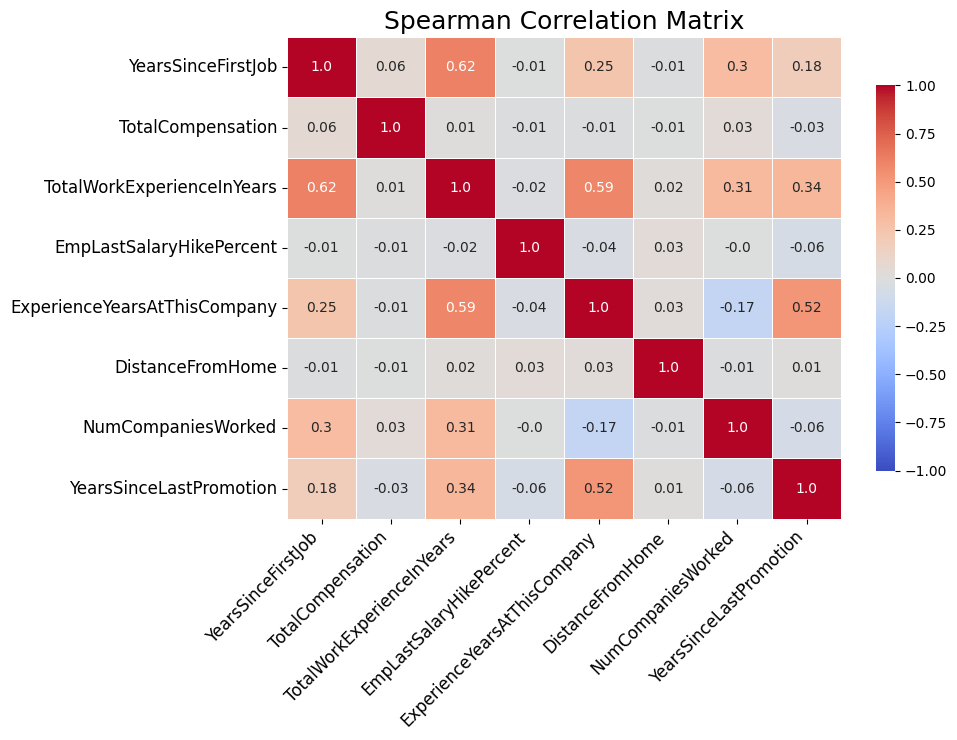

In [29]:
spearman_correlation(data, data_not_normal_df1, exclude_target='PerformanceRating', multicollinearity_threshold=0.8)

In [30]:
above_threshold1, below_threshold1 = calculate_vif(data, exclude_target='PerformanceRating', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
                   Feature       VIF
        YearsSinceFirstJob 11.199545
  EmpLastSalaryHikePercent  9.599034
TotalWorkExperienceInYears  9.421159
         TotalCompensation  8.539042

Features with VIF <= threshold (Low/No Multicollinearity):
                     Feature      VIF
ExperienceYearsAtThisCompany 6.309133
          NumCompaniesWorked 2.666313
     YearsSinceLastPromotion 2.471022
            DistanceFromHome 2.218967


Two new engineered features—YearsSinceFirstJob and TotalCompensation—were added, and they enhance the dataset’s depth with realistic proxies for professional maturity and earnings. No logical violations or anomalies were introduced in their creation.

After dropping Age, EmpHourlyRate, YearsWithCurrManager, and ExperienceYearsInCurrentRole (due to multicollinearity), the remaining structure is cleaner and more robust. Normality checks confirm continued non-normal distribution for all numeric features, but now no multicollinear pairs remain based on Spearman correlation.

However, VIF still flags four features above the threshold of 8:

YearsSinceFirstJob (VIF ≈ 11.2)

EmpLastSalaryHikePercent (VIF ≈ 9.6)

TotalWorkExperienceInYears (VIF ≈ 9.4)

TotalCompensation (VIF ≈ 8.5)

These features might be structurally related—for instance, total compensation loosely scales with experience. Still, since no strong pairwise correlation exists, they likely contribute unique aspects in multivariate space. Unless model sensitivity demands strict VIF control, these can be retained.

This version of the dataset is now clean, domain-consistent, feature-rich, and statistically balanced—well-suited for modeling and interpretation.










In [31]:
# Identify predictors (excluding target)
categorical_predictors = [col for col in data.select_dtypes(include="category").columns if col != "PerformanceRating"]
numerical_predictors = [col for col in data.select_dtypes(include="number").columns]
# Chi-Square tests (Categorical vs. PerformanceRating)
chi_square_results = []
for col in categorical_predictors:
    try:
        contingency = pd.crosstab(data[col], data["PerformanceRating"])
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        chi_square_results.append((col, chi2, p))
    except Exception as e:
        chi_square_results.append((col, None, None))
# Kruskal-Wallis tests (Numerical vs. PerformanceRating)
kruskal_results = []
for col in numerical_predictors:
    try:
        groups = [group[col].values for name, group in data.groupby("PerformanceRating")]
        stat, p = stats.kruskal(*groups)
        kruskal_results.append((col, stat, p))
    except Exception as e:
        kruskal_results.append((col, None, None))
# Create DataFrames from results
chi_df = pd.DataFrame(chi_square_results, columns=["Feature", "Chi2 Stat", "p-value"])
kruskal_df = pd.DataFrame(kruskal_results, columns=["Feature", "Kruskal Stat", "p-value"])
# Format p-values to human-readable format with 4 decimal places or scientific notation
chi_df["p-value"] = chi_df["p-value"].apply(lambda x: f"{x:.4e}" if x is not None else "N/A")
kruskal_df["p-value"] = kruskal_df["p-value"].apply(lambda x: f"{x:.4e}" if x is not None else "N/A")

In [32]:
chi_df

,Feature,Chi2 Stat,p-value
0,Gender,0.162950,9.2176e-01
1,EducationBackground,10.217388,4.2163e-01
2,MaritalStatus,6.133323,1.8941e-01
3,EmpDepartment,70.327960,3.8321e-11
4,EmpJobRole,97.740688,1.3111e-07
5,BusinessTravelFrequency,4.397274,3.5490e-01
6,EmpEducationLevel,9.377289,3.1147e-01
7,EmpEnvironmentSatisfaction,325.548126,2.7265e-67
8,EmpJobInvolvement,1.765091,9.3999e-01
9,EmpJobLevel,11.462051,1.7687e-01


In [33]:
kruskal_df

,Feature,Kruskal Stat,p-value
0,DistanceFromHome,1.913497,3.8414e-01
1,NumCompaniesWorked,1.818423,4.0284e-01
2,EmpLastSalaryHikePercent,235.589750,6.9556e-52
3,TotalWorkExperienceInYears,9.517587,8.5760e-03
4,ExperienceYearsAtThisCompany,29.520206,3.8884e-07
5,YearsSinceLastPromotion,125.434691,5.7837e-28
6,YearsSinceFirstJob,2.539260,2.8094e-01
7,TotalCompensation,2.992852,2.2393e-01


The results show that several features have a statistically significant influence on performance. EmpEnvironmentSatisfaction has the strongest association with a p-value of 2.7e-67, indicating a powerful link between how employees perceive their environment and how they're rated. EmpLastSalaryHikePercent also stands out with a Kruskal-Wallis p-value of 6.9e-52, confirming that salary adjustments are closely tied to performance levels. YearsSinceLastPromotion follows with a p-value of 5.7e-28, showing that delays in promotion are common among lower-rated employees. Department and job role both show strong chi-square associations, with p-values of 3.8e-11 and 1.3e-07 respectively, suggesting clear performance patterns tied to organizational structure. Work-life balance (p = 7.9e-05) and overtime (p = 0.0035) are also influential, where excessive workload or poor balance can negatively impact performance. In contrast, features like Gender (p = 0.92), EducationBackground (p = 0.42), and TotalCompensation (p = 0.22) show no significant relationship, indicating they are less useful as predictors. These numbers help isolate the features that truly matter in understanding and predicting employee performance.

## Encoding

In [34]:
# Nominal (unordered) features
nominal_features = [
    "Gender", "EducationBackground", "MaritalStatus",
    "EmpDepartment", "EmpJobRole", "BusinessTravelFrequency"
]
# Separate high-cardinality from low-cardinality features
low_card_nominals = [col for col in nominal_features if data[col].nunique() <= 6]
high_card_nominals = [col for col in nominal_features if data[col].nunique() > 6]
# One-hot encode low-cardinality nominal features
data_encoded = pd.get_dummies(data, columns=low_card_nominals, drop_first=True)
# Frequency encode high-cardinality nominal features (e.g., EmpJobRole)
for col in high_card_nominals:
    freq_map = data[col].value_counts(normalize=True)
    data_encoded[col + "_freq"] = data[col].map(freq_map)
# Drop original high-cardinality nominal columns
data_encoded = data_encoded.drop(columns=high_card_nominals)
# Show result
data_encoded.head()

,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,YearsSinceLastPromotion,Attrition,PerformanceRating,YearsSinceFirstJob,TotalCompensation,Gender_Male,EducationBackground_Life Sciences,EducationBackground_Marketing,EducationBackground_Medical,EducationBackground_Other,EducationBackground_Technical Degree,MaritalStatus_Married,MaritalStatus_Single,EmpDepartment_Development,EmpDepartment_Finance,EmpDepartment_Human Resources,EmpDepartment_Research & Development,EmpDepartment_Sales,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,EmpJobRole_freq
0,10,3,4,3,2,4,1,No,12,4,10,2,2,10,0,No,3,16,114400,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,0.2250
1,14,4,4,3,2,1,2,No,12,4,20,2,3,7,1,No,3,29,87360,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,0.2250
2,5,4,4,2,3,1,5,Yes,21,3,20,2,3,18,1,No,4,22,99840,True,True,False,False,False,False,True,False,False,False,False,False,True,True,False,0.2250
3,10,4,2,2,5,4,3,No,15,2,23,2,2,20,10,No,3,23,151840,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.0425
4,16,4,1,3,2,1,8,No,14,4,10,1,3,2,2,No,3,42,174720,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,0.2250


In [35]:
corrected_ordinal_mappings = {
    "EmpEducationLevel": [1, 2, 3, 4, 5],  
    "EmpEnvironmentSatisfaction": [1, 2, 3, 4],  
    "EmpJobInvolvement": [1, 2, 3, 4],  
    "EmpJobLevel": [1, 2, 3, 4, 5],  
    "EmpJobSatisfaction": [1, 2, 3, 4], 
    "EmpRelationshipSatisfaction": [1, 2, 3, 4],
    "EmpWorkLifeBalance": [1, 2, 3, 4],  
    "TrainingTimesLastYear": sorted(data["TrainingTimesLastYear"].dropna().unique()),  
    "PerformanceRating": [1, 2, 3, 4]  
}
# Apply ordinal encoding using defined category order
from pandas.api.types import CategoricalDtype
for col, order in corrected_ordinal_mappings.items():
    cat_type = CategoricalDtype(categories=order, ordered=True)
    data_encoded[col] = data[col].astype(cat_type).cat.codes
# Preview encoded values
data_encoded[list(corrected_ordinal_mappings.keys())].head()

,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,EmpRelationshipSatisfaction,EmpWorkLifeBalance,TrainingTimesLastYear,PerformanceRating
0,2,3,2,1,3,3,1,2,2
1,3,3,2,1,0,3,2,2,2
2,3,3,1,2,0,2,2,2,3
3,3,1,1,4,3,1,1,2,2
4,3,0,2,1,0,3,2,1,2


In [36]:
# Binary features to encode: OverTime, Attrition
binary_map = {'Yes': 1, 'No': 0}
# Apply mapping
data_encoded["OverTime"] = data["OverTime"].map(binary_map)
data_encoded["Attrition"] = data["Attrition"].map(binary_map)
# Show result
data_encoded[["OverTime", "Attrition"]].head()

,OverTime,Attrition
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [37]:
data_encoded["OverTime"] = data_encoded["OverTime"].astype("int8")
data_encoded["Attrition"] = data_encoded["Attrition"].astype("int8")

In [38]:
columns_info("Dataset Overview", data_encoded)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     19         Gender_Male                    bool            N/A                            2
2     20         EducationBackground_Life Sciences bool            N/A                            2
3     21         EducationBackground_Marketing  bool            N/A                            2
4     22         EducationBackground_Medical    bool            N/A                            2
5     23         EducationBackground_Other      bool            N/A                            2
6     24         EducationBackground_Technical Degree bool            N/A                            2
7     25         MaritalStatus_Married          bool            N/A                            2
8     26         MaritalStatus_Single           bo

Encoding was performed in a structured and context-aware manner to ensure all features were numerically compatible for modeling. Low-cardinality nominal variables such as Gender, MaritalStatus, and EmpDepartment were one-hot encoded, reducing them to binary flags. High-cardinality columns like EmpJobRole were frequency encoded, preserving distributional information without expanding dimensionality excessively. Ordinal features such as satisfaction scores and education levels were converted using custom-ordered integer mappings aligned with domain logic, where higher values represent better or more advanced levels. Binary features like OverTime and Attrition were mapped to 0 and 1 for clarity and consistency.

Following this transformation, the dataset contains 36 predictors plus the target, all in numeric form. Variables now span a clean range—DistanceFromHome goes from 1 to 29, YearsSinceFirstJob from 2 to 47, and TotalCompensation from 62,400 to 208,000. Encoded ordinal features fall into expected ranges (e.g., EmpJobSatisfaction from 0 to 3). No multicollinearity or structure-breaking issues were introduced, and the data is now fully ready for model training, feature selection, and evaluation.

## Model-Based Feature Importance and Validate with Permutation Importance

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


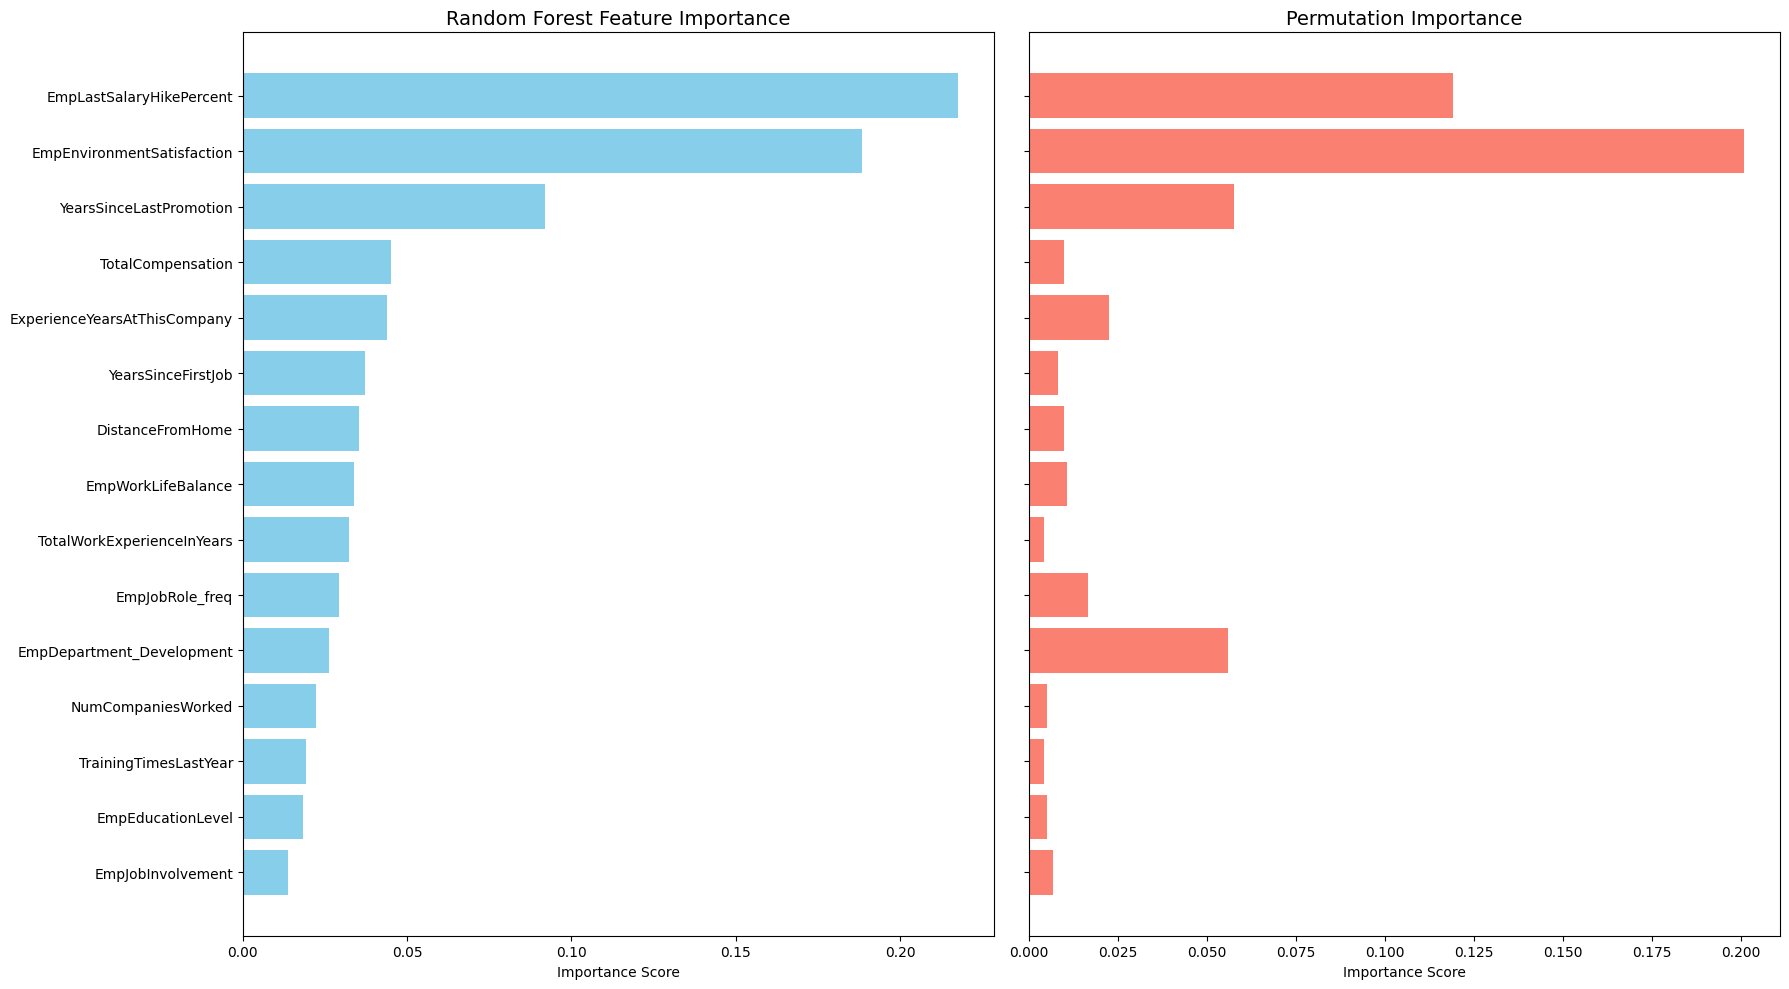


 Features by Both Methods (Sorted by RF Importance):
                                  Feature  Importance_RF  Importance_Perm
                 EmpLastSalaryHikePercent       0.217729         0.119167
               EmpEnvironmentSatisfaction       0.188467         0.200833
                  YearsSinceLastPromotion       0.091848         0.057500
                        TotalCompensation       0.045072         0.010000
             ExperienceYearsAtThisCompany       0.043734         0.022500
                       YearsSinceFirstJob       0.037179         0.008333
                         DistanceFromHome       0.035256         0.010000
                       EmpWorkLifeBalance       0.033949         0.010833
               TotalWorkExperienceInYears       0.032290         0.004167
                          EmpJobRole_freq       0.029358         0.016667
                EmpDepartment_Development       0.026318         0.055833
                       NumCompaniesWorked       0.022302  

In [40]:
X = data_encoded.drop(columns=["PerformanceRating"])
y = data_encoded["PerformanceRating"]

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
# Train Random Forest with class weighting for imbalance
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
# Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
# Permutation Importance (more reliable, slower)
perm_result = permutation_importance(
    rf, X_test, y_test,
    n_repeats=5, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean
}).sort_values('Importance', ascending=False)
# Combine ranks from both methods
feature_importance['Rank_RF'] = feature_importance['Importance'].rank(ascending=False)
perm_df['Rank_Perm'] = perm_df['Importance'].rank(ascending=False)
avg_rank = pd.merge(
    feature_importance[['Feature', 'Rank_RF']],
    perm_df[['Feature', 'Rank_Perm']],
    on='Feature'
)
avg_rank['Avg_Rank'] = avg_rank[['Rank_RF', 'Rank_Perm']].mean(axis=1)
# Select top N features
top_features = avg_rank.sort_values('Avg_Rank').head(15)['Feature'].tolist()
# Filter and sort for plotting
top_rf = feature_importance[feature_importance['Feature'].isin(top_features)].sort_values('Importance', ascending=True)
top_perm = perm_df[perm_df['Feature'].isin(top_features)].sort_values('Importance', ascending=True)
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)
axes[0].barh(top_rf['Feature'], top_rf['Importance'], color='skyblue')
axes[0].set_title('Random Forest Feature Importance', fontsize=14)
axes[0].set_xlabel('Importance Score')
axes[1].barh(top_perm['Feature'], top_perm['Importance'], color='salmon')
axes[1].set_title('Permutation Importance', fontsize=14)
axes[1].set_xlabel('Importance Score')
plt.tight_layout()
plt.show()
# Merge for comparison and correlation
combined = pd.merge(
    feature_importance[['Feature', 'Importance']],
    perm_df[['Feature', 'Importance']],
    on='Feature',
    suffixes=('_RF', '_Perm')
)
top_combined = combined.sort_values("Importance_RF", ascending=False).reset_index(drop=True)
correlation = np.corrcoef(combined['Importance_RF'], combined['Importance_Perm'])[0, 1]
print("\n Features by Both Methods (Sorted by RF Importance):")
print(top_combined.to_string(index=False))
print(f"\n Correlation between methods: {correlation:.2f}")

Feature importance was assessed using both Random Forest Gini-based importance and permutation importance, revealing a strong agreement between the two approaches (correlation = 0.91). The top three predictors consistently across both methods were EmpLastSalaryHikePercent, EmpEnvironmentSatisfaction, and YearsSinceLastPromotion. Notably, EmpLastSalaryHikePercent ranked highest by Random Forest, while EmpEnvironmentSatisfaction had the highest score in permutation importance—indicating its true predictive influence when accounting for interactions.

Additionally, variables like TotalCompensation, ExperienceYearsAtThisCompany, and YearsSinceFirstJob also contributed meaningfully to the model, albeit to a lesser extent. Some features such as EmpDepartment_Development showed low importance in Random Forest but relatively higher values under permutation, suggesting that their influence may not be captured through direct splits but via their effect on prediction accuracy. Overall, the top 15 features captured both compensation, tenure, satisfaction, and role-based information, aligning well with HR performance theory and model interpretability goals.

---

In [41]:
# Final feature list
final_features = [
    'EmpLastSalaryHikePercent',
    'EmpEnvironmentSatisfaction',
    'YearsSinceLastPromotion',
    'ExperienceYearsAtThisCompany',
    'EmpDepartment_Development',
    'EmpJobRole_freq',
    'EmpWorkLifeBalance',
    'OverTime',
    'EmpJobSatisfaction',
    'TotalWorkExperienceInYears',
    'DistanceFromHome',
    'PerformanceRating'  
]

# Filter the DataFrame
final_data = data_encoded[final_features]

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 0



<Figure size 2000x800 with 0 Axes>

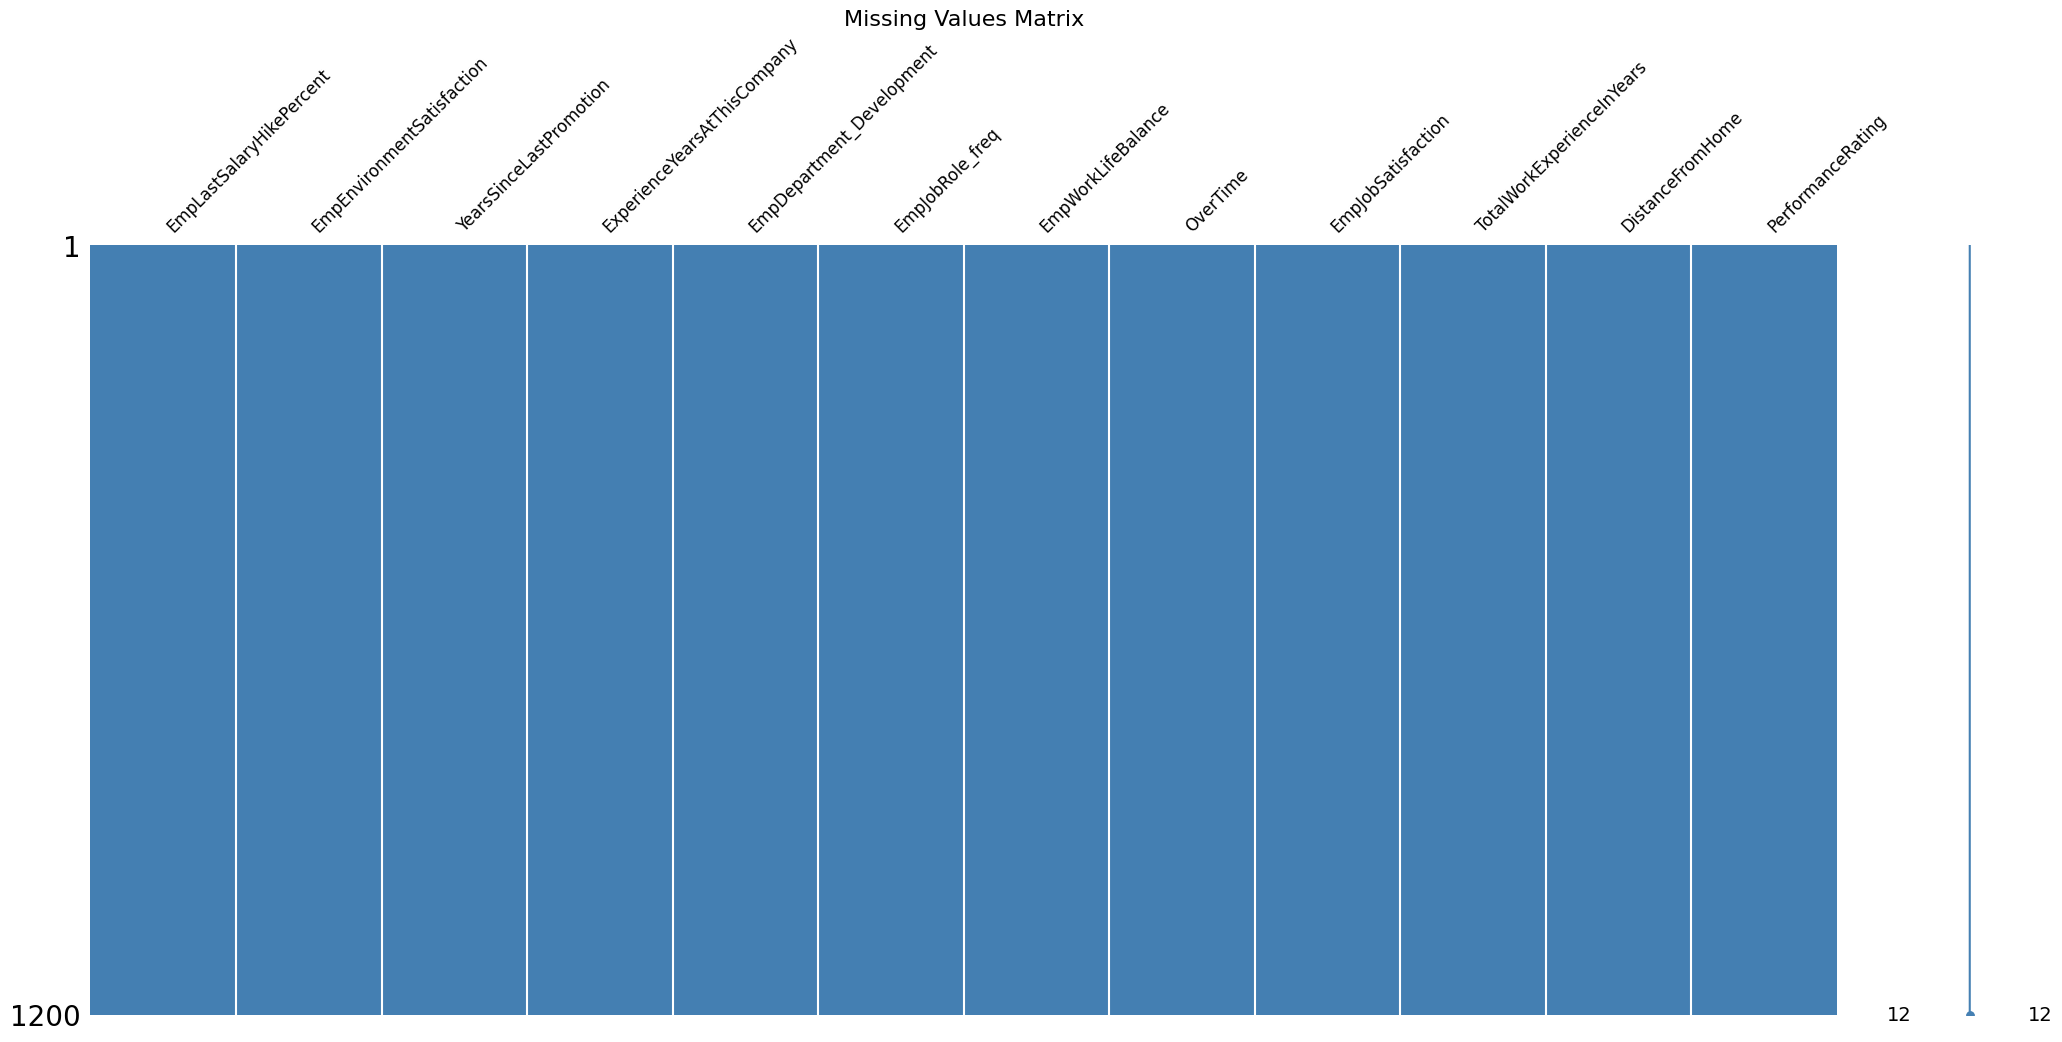

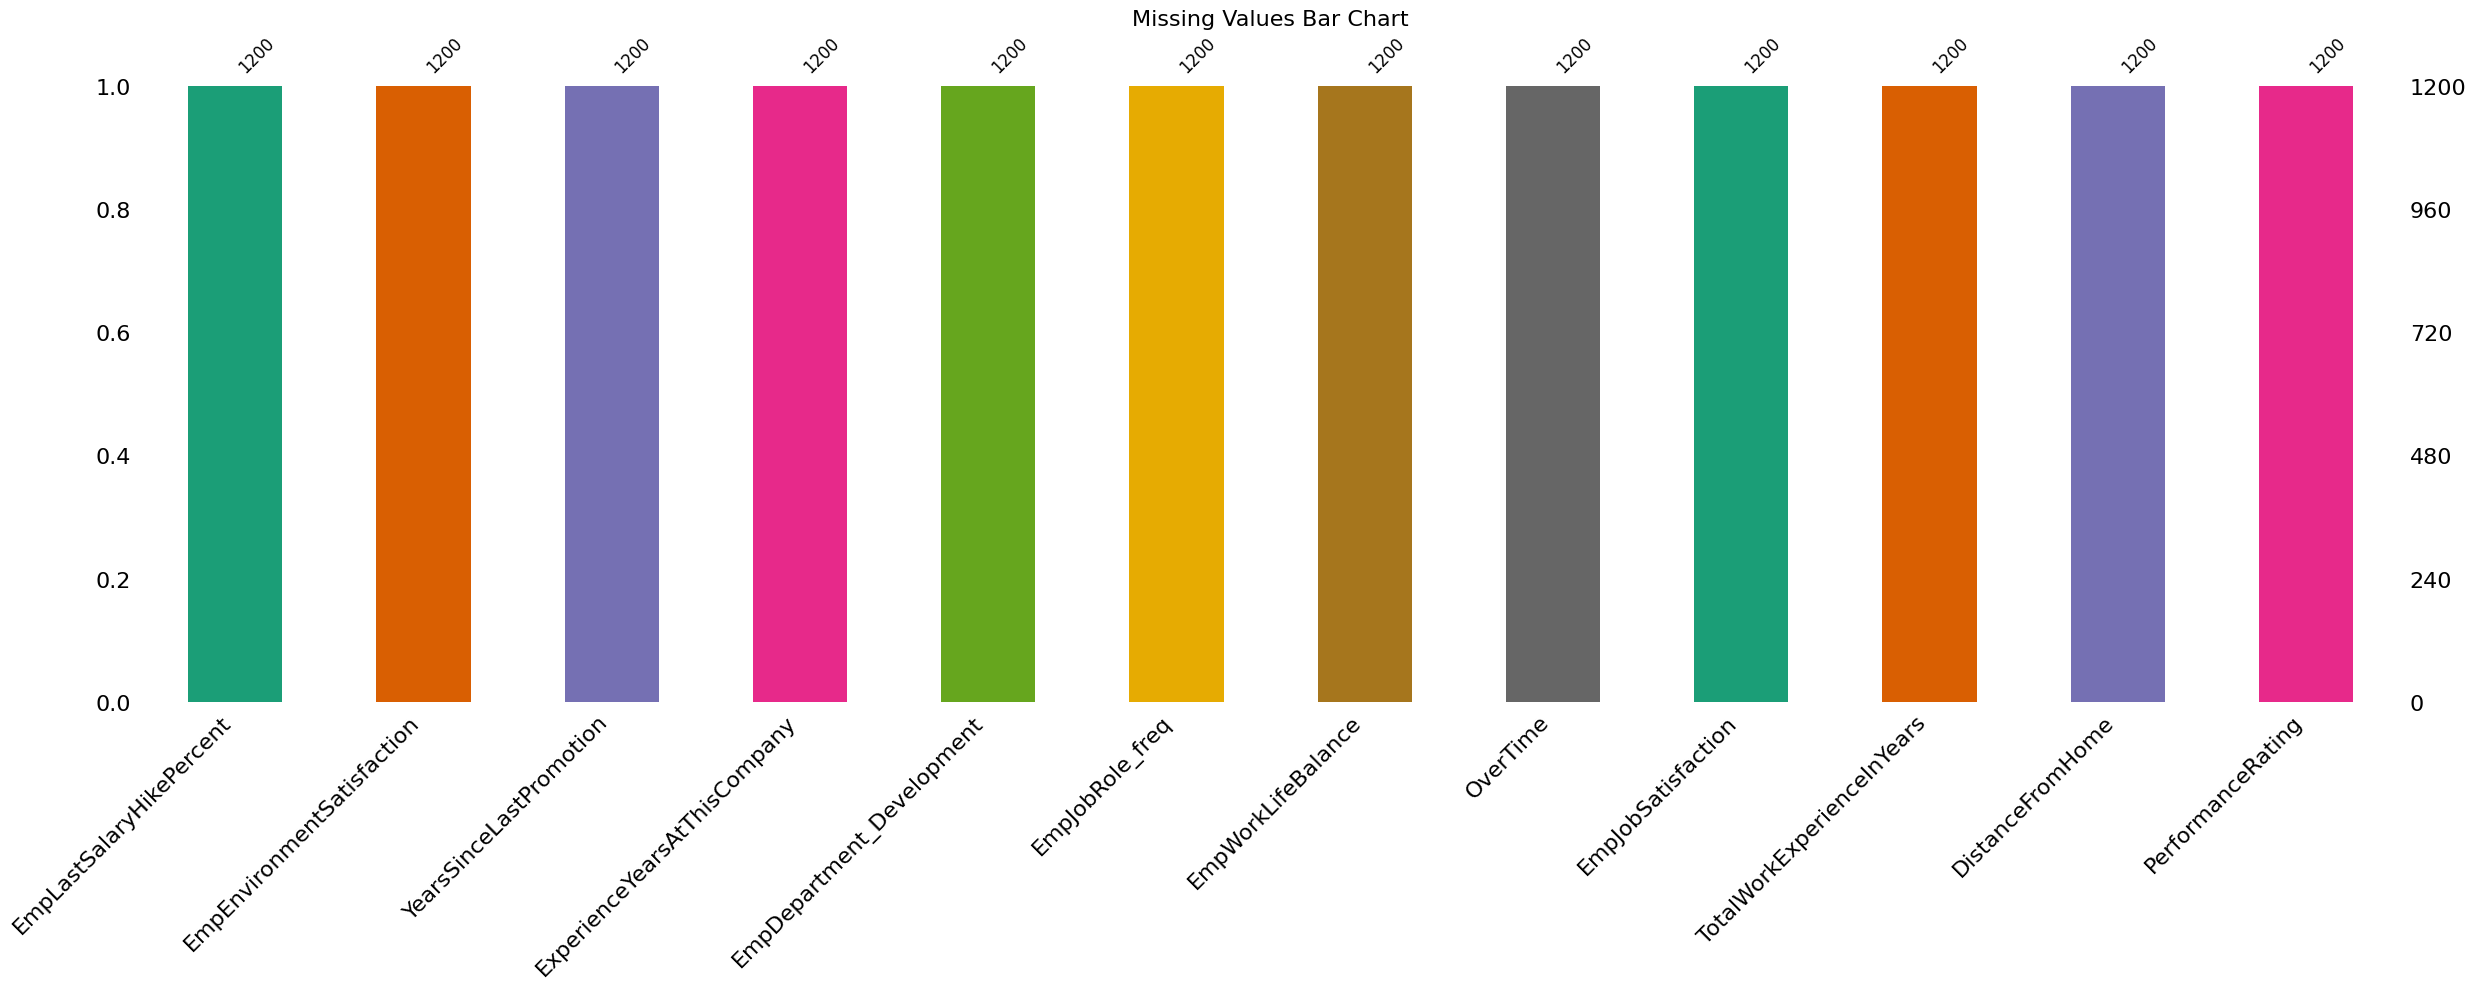

In [42]:
missing_inf_values(final_data)
print(f"\nNumber of duplicate rows: {final_data.duplicated().sum()}\n")
duplicates = final_data[final_data.duplicated()]
duplicates
show_missing(final_data)

In [43]:
# Save to CSV
output_path = r"D:\INX_Future_Employee_Performance_Project\data\processed\prepared_data.csv"
final_data.to_csv(output_path, index=False)
print(f" Final data saved to: {output_path}")

 Final data saved to: D:\INX_Future_Employee_Performance_Project\data\processed\prepared_data.csv


The final feature set was carefully selected based on both model-based and statistical importance. It includes 12 variables that capture key aspects of employee performance such as salary progression, job satisfaction, work-life balance, and tenure—all of which demonstrated consistent predictive power. Importantly, the dataset contains no missing, infinite, or duplicate values, ensuring high data integrity for downstream modeling. Visual summaries confirmed good distribution and separation across the target variable (PerformanceRating). The cleaned and encoded dataset has been successfully exported to the designated path as a ready-to-model CSV file.

---

next step will be model building in "model_development"